In [13]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

In [14]:
print("Tensorflow version: ", tf.__version__)
print(tf.config.list_physical_devices("GPU"))

Tensorflow version:  2.9.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [15]:
dir_path = os.path.join("database", "text_classification")

with open (os.path.join(dir_path, "ro.json")) as f:
    data = json.load(f)
    df = pd.DataFrame(data)

df

,text,label
0,A aparut ceva nou in simptomatologia dumneavoa...,symptoms_changes
1,Alte probleme de sanatate ati avut,diseases_personal
2,Ati avut frisoane de curand,fever_symptoms
3,Ati avut o interventie chirurgicala,surgeries
4,Ati avut tuse cu sputa,cough_symptoms
...,...,...
186,și tu de vreo boală de care suferă tatăl dumne...,diseases_parents
187,știi tu de vreo boala de care suferă tatăl tău,diseases_parents
188,știți de vreo boală de care suferă mama dumnea...,diseases_parents
189,știți de vreo boală de care suferă mama sau ta...,diseases_parents


In [16]:
df.drop_duplicates(["text"], ignore_index=True)

,text,label
0,A aparut ceva nou in simptomatologia dumneavoa...,symptoms_changes
1,Alte probleme de sanatate ati avut,diseases_personal
2,Ati avut frisoane de curand,fever_symptoms
3,Ati avut o interventie chirurgicala,surgeries
4,Ati avut tuse cu sputa,cough_symptoms
...,...,...
186,și tu de vreo boală de care suferă tatăl dumne...,diseases_parents
187,știi tu de vreo boala de care suferă tatăl tău,diseases_parents
188,știți de vreo boală de care suferă mama dumnea...,diseases_parents
189,știți de vreo boală de care suferă mama sau ta...,diseases_parents


In [17]:
df["label"].value_counts()

visit_reason              40
symptoms_start            18
diseases_parents          18
fainting_symptoms         16
chronic_treatment         15
symptoms_circumstances    13
symptoms_changes          12
fever_symptoms            12
palpitations_symptoms     12
diseases_personal         10
greetings                  8
cough_symptoms             7
surgeries                  5
chest_pain                 5
Name: label, dtype: int64

In [18]:
dir_path = os.path.join("database", "personas")

with open(os.path.join(dir_path, "ro_personas.json")) as f:
    data = json.load(f)
    texts = []
    labels = []
    for persona in data:
        for dialog_entity in persona["dialog"]:
            if not "questions" in dialog_entity:
                print(dialog_entity)
            
            for question in dialog_entity["questions"]:
                texts.append(question)
                labels.append(dialog_entity["label"])
    df_persona = pd.DataFrame(
        {
            "text": texts,
            "label": labels
        }
    )
df_persona.head()

,text,label
0,Care este motivul prezentarii la spital?,visit_reason
1,Cand a debutat simptomatologia?,symptoms_start
2,Care sunt circumstantele aparitiei simptomatol...,symptoms_circumstances
3,Au exisat modificari in simptomatologie de la ...,symptoms_changes
4,Stiti vreo boala de care sufera mama sau tatal...,diseases_parents


In [19]:
df_persona = df_persona.drop_duplicates(["text"], ignore_index=True)

In [20]:
df_combined = pd.concat([df, df_persona], ignore_index=True)
label_to_idx = {label: idx for idx, label in enumerate(df_combined["label"].unique())}
label_to_idx

{'symptoms_changes': 0,
 'diseases_personal': 1,
 'fever_symptoms': 2,
 'surgeries': 3,
 'cough_symptoms': 4,
 'fainting_symptoms': 5,
 'palpitations_symptoms': 6,
 'greetings': 7,
 'symptoms_start': 8,
 'visit_reason': 9,
 'chronic_treatment': 10,
 'symptoms_circumstances': 11,
 'chest_pain': 12,
 'diseases_parents': 13}

In [21]:
df_combined["label_id"] = df_combined["label"].apply(lambda s: label_to_idx[s])
df_combined.head()

,text,label,label_id
0,A aparut ceva nou in simptomatologia dumneavoa...,symptoms_changes,0
1,Alte probleme de sanatate ati avut,diseases_personal,1
2,Ati avut frisoane de curand,fever_symptoms,2
3,Ati avut o interventie chirurgicala,surgeries,3
4,Ati avut tuse cu sputa,cough_symptoms,4


In [22]:
train_df = df_combined.groupby("label").sample(frac=0.8, random_state=42)
valid_df = df_combined.drop(train_df.index)

In [23]:
train_df.shape, valid_df.shape

((171, 3), (44, 3))

In [24]:
batch_size = 12

train_dataset = (tf.data.Dataset
                 .from_tensor_slices((train_df["text"], train_df["label_id"]))
                 .batch(batch_size))

valid_dataset = (tf.data.Dataset
                 .from_tensor_slices((valid_df["text"], valid_df["label_id"]))
                 .batch(batch_size))

In [25]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)

encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/2",
    trainable=True)

# encoder = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/2",
#     trainable=True)

# encoder = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/2",
#     trainable=True)

encoder_outputs = encoder(encoder_inputs)
outputs = tf.keras.layers.Dense(len(label_to_idx), name="class_output")(encoder_outputs["pooled_output"])

model = tf.keras.Model(inputs=text_input, outputs=[outputs, encoder_outputs["pooled_output"]])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss={
        "class_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    },
    metrics={
        "class_output": [tf.keras.metrics.SparseCategoricalAccuracy()]
    }
)

In [27]:
epochs = 100

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset
)

Epoch 1/100
15/15 [==============================] - 13s 356ms/step - loss: 3.0357 - sparse_categorical_accuracy: 0.0409 - val_loss: 2.7391 - val_sparse_categorical_accuracy: 0.0909
Epoch 2/100
15/15 [==============================] - 4s 279ms/step - loss: 2.7686 - sparse_categorical_accuracy: 0.0819 - val_loss: 2.6007 - val_sparse_categorical_accuracy: 0.1136
Epoch 3/100
15/15 [==============================] - 5s 322ms/step - loss: 2.6579 - sparse_categorical_accuracy: 0.1111 - val_loss: 2.4913 - val_sparse_categorical_accuracy: 0.2727
Epoch 4/100
15/15 [==============================] - 5s 329ms/step - loss: 2.5538 - sparse_categorical_accuracy: 0.2105 - val_loss: 2.4207 - val_sparse_categorical_accuracy: 0.3182
Epoch 5/100
15/15 [==============================] - 5s 353ms/step - loss: 2.5353 - sparse_categorical_accuracy: 0.1871 - val_loss: 2.3690 - val_sparse_categorical_accuracy: 0.2955
Epoch 6/100
15/15 [==============================] - 5s 329ms/step - loss: 2.5122 - sparse_cat

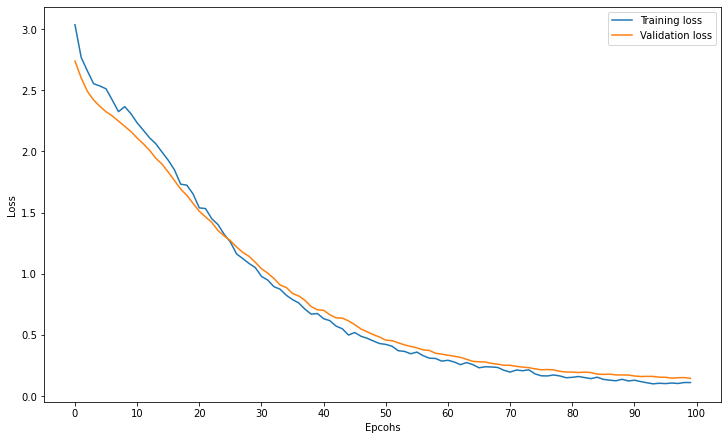

In [34]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
ax.plot(history.history["loss"], label="Training loss")
ax.plot(history.history["val_loss"], label="Validation loss")
ax.set_xlabel("Epcohs")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, len(history.history["loss"]) + 1, 10))
ax.legend()
plt.savefig("loss.png")

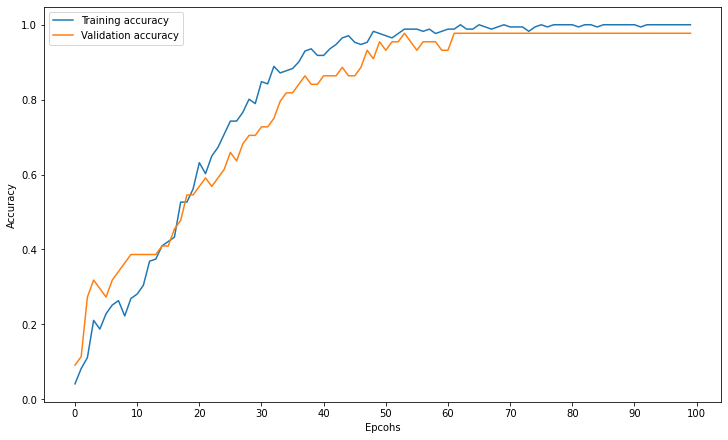

In [29]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
ax.plot(history.history["class_output_sparse_categorical_accuracy"], label="Training accuracy")
ax.plot(history.history["val_class_output_sparse_categorical_accuracy"], label="Validation accuracy")
ax.set_xlabel("Epcohs")
ax.set_ylabel("Accuracy")
ax.set_xticks(np.arange(0, len(history.history["class_output_sparse_categorical_accuracy"]) + 1, 10))
ax.legend()
fig.savefig("accuracy.png")

In [30]:
metrics = model.evaluate(
    df_combined["text"].to_numpy(),
    df_combined["label_id"].to_numpy()
)

for metric_name, metric in zip(model.metrics_names, metrics):
    print(f"{metric_name:<8s}: {metric:.4f}")

7/7 [==============================] - 2s 315ms/step - loss: 0.0602 - sparse_categorical_accuracy: 0.9953
loss    : 0.0602
sparse_categorical_accuracy: 0.9953


In [31]:
predictions_probabilities = model.predict(df_combined["text"])
predictions = np.argmax(predictions_probabilities, axis=1)

y_true = df_combined["label_id"].to_numpy()
accuracy = accuracy_score(y_true, predictions)
precision = precision_score(y_true, predictions, average="macro")
recall = precision_score(y_true, predictions, average="macro")
f1score = f1_score(y_true, predictions, average="macro")

print(f"accuracy : {accuracy:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall   : {recall:.4f}")
print(f"F1       : {f1score:.4f}")

7/7 [==============================] - 3s 346ms/step
accuracy : 0.9953
precision: 0.9984
recall   : 0.9984
F1       : 0.9965


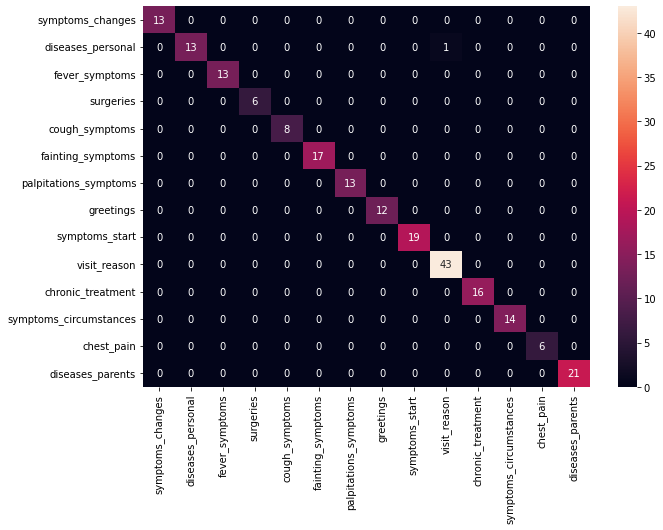

In [32]:
matrix = confusion_matrix(y_true, predictions)
index = label_to_idx.keys()
df = pd.DataFrame(matrix, index=index, columns=index)
plt.figure(figsize=(10, 7))
sns.heatmap(df, annot=True, fmt="d")
plt.savefig("confusion_matrix.png")

In [33]:
model.save("bert_classification")

INFO:tensorflow:Assets written to: bert_classification\assets


INFO:tensorflow:Assets written to: bert_classification\assets
